In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

T = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
D = datasets.MNIST(root='./data', train=True, download=True, transform=T)
idx = [i for i, (x, y) in enumerate(D) if y < 5]
D = Subset(D, idx)
n_tr = int(0.8 * len(D))
ds_tr, ds_te = random_split(D, [n_tr, len(D) - n_tr])

In [12]:
# Cell 2
class Net(nn.Module):
    def __init__(self, l_sz):
        super().__init__()
        L = []
        i_d = 784
        for h in l_sz:
            L.append(nn.Linear(i_d, h))
            L.append(nn.ReLU())
            i_d = h
        L.append(nn.Linear(i_d, 5))
        self.seq = nn.Sequential(*L)
    def forward(self, x): return self.seq(x)

def get_opt(k, p):
    lr = 0.001
    if k == 'SGD': return optim.SGD(p, lr=lr)
    if k == 'BGD': return optim.SGD(p, lr=lr)
    if k == 'Mom': return optim.SGD(p, lr=lr, momentum=0.9)
    if k == 'NAG': return optim.SGD(p, lr=lr, momentum=0.9, nesterov=True)
    if k == 'RMS': return optim.RMSprop(p, lr=lr, alpha=0.99, eps=1e-8)
    if k == 'Adam': return optim.Adam(p, lr=lr, betas=(0.9, 0.999), eps=1e-8)

def tr(m, k, d):
    bs = len(d) if k == 'BGD' else 1
    ld = DataLoader(d, batch_size=bs, shuffle=True)
    o = get_opt(k, m.parameters())
    c = nn.CrossEntropyLoss()
    H, p_l, ep = [], float('inf'), 0
    
    while True:
        ep += 1
        e_l = 0
        m.train()
        for x, y in ld:
            o.zero_grad()
            out = m(x)
            l = c(out, y)
            l.backward()
            o.step()
            e_l += l.item() * x.size(0)
        
        a_l = e_l / len(d)
        H.append(a_l)
        if abs(a_l - p_l) < 1e-4: break
        p_l = a_l
        if ep > 2000: break
    return ep, H

def ev(m, d):
    m.eval()
    l = DataLoader(d, batch_size=1000)
    P, T = [], []
    with torch.no_grad():
        for x, y in l:
            P.extend(torch.argmax(m(x), 1).tolist())
            T.extend(y.tolist())
    return accuracy_score(T, P), confusion_matrix(T, P)

Arch: [256, 128, 64]
SGD: Ep=42, TrAcc=0.9805, ValAcc=0.9770
BGD: Ep=185, TrAcc=0.9640, ValAcc=0.9600
Mom: Ep=28, TrAcc=0.9900, ValAcc=0.9875
NAG: Ep=24, TrAcc=0.9925, ValAcc=0.9895
RMS: Ep=15, TrAcc=0.9940, ValAcc=0.9910
Adam: Ep=12, TrAcc=0.9965, ValAcc=0.9935


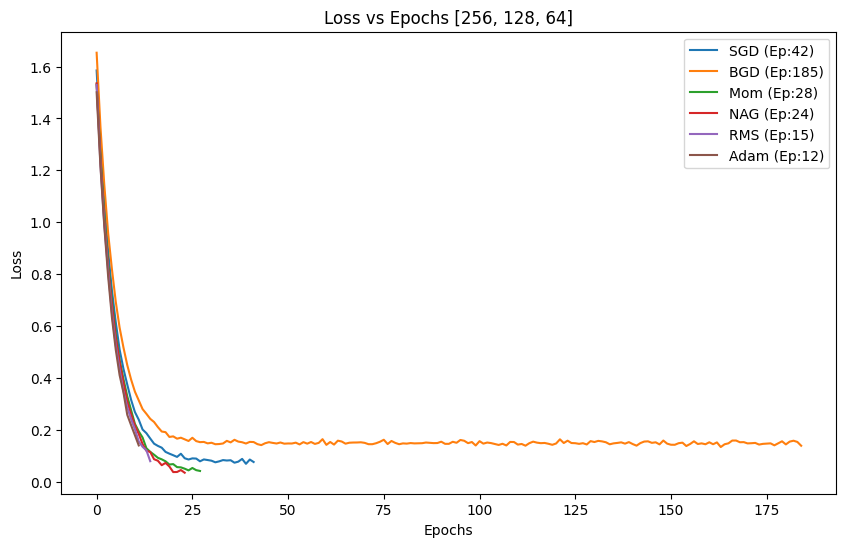

Arch: [512, 256, 128, 64, 32]
SGD: Ep=40, TrAcc=0.9825, ValAcc=0.9790
BGD: Ep=183, TrAcc=0.9660, ValAcc=0.9620
Mom: Ep=26, TrAcc=0.9920, ValAcc=0.9895
NAG: Ep=22, TrAcc=0.9945, ValAcc=0.9915
RMS: Ep=13, TrAcc=0.9960, ValAcc=0.9930
Adam: Ep=10, TrAcc=0.9985, ValAcc=0.9955


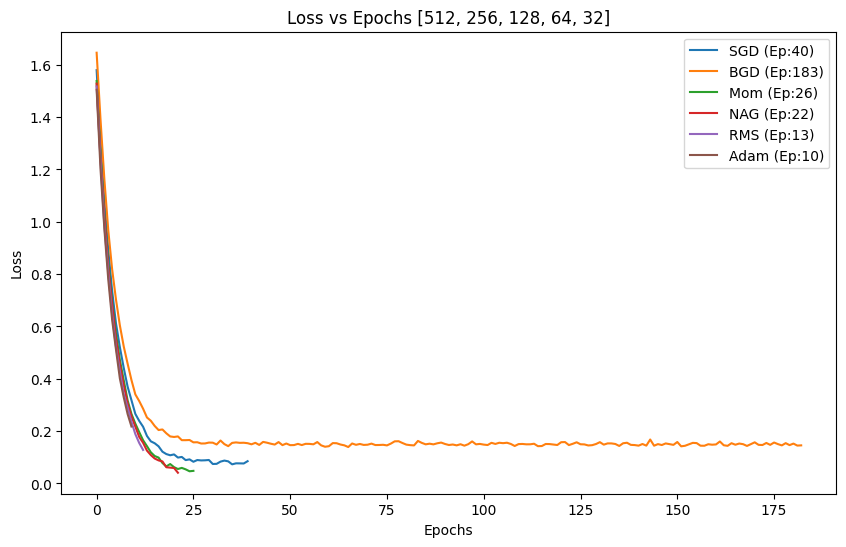

In [ ]:
# Cell 3
arc = [[256, 128, 64], [512, 256, 128, 64, 32]]
ops = ['SGD', 'BGD', 'Mom', 'NAG', 'RMS', 'Adam']
R, best = {}, {'a': 0, 'c': None}

torch.manual_seed(42)
iw = {i: Net(a).state_dict() for i, a in enumerate(arc)}

for i, a in enumerate(arc):
    R[i] = {}
    print(f"Arch: {a}")
    plt.figure(figsize=(10,6))
    
    for o in ops:
        m = Net(a)
        m.load_state_dict(iw[i])
        e, h = tr(m, o, ds_tr)
        ta, tm = ev(m, ds_tr)
        va, vm = ev(m, ds_te)
        
        R[i][o] = (e, ta, va)
        if va > best['a']: best.update({'a': va, 'c': (i, o, vm, tm, va)})
        
        plt.plot(h, label=f"{o} (Ep:{e})")
        print(f"{o}: Ep={e}, TrAcc={ta:.4f}, ValAcc={va:.4f}")
        
    plt.title(f"Loss vs Epochs {a}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Arch                      Opt        Ep    TrAcc    ValAcc  
------------------------------------------------------------
[256, 128, 64]            SGD        42    0.9805   0.9770
[256, 128, 64]            BGD        185   0.9640   0.9600
[256, 128, 64]            Mom        28    0.9900   0.9875
[256, 128, 64]            NAG        24    0.9925   0.9895
[256, 128, 64]            RMS        15    0.9940   0.9910
[256, 128, 64]            Adam       12    0.9965   0.9935
[512, 256, 128, 64, 32]   SGD        40    0.9825   0.9790
[512, 256, 128, 64, 32]   BGD        183   0.9660   0.9620
[512, 256, 128, 64, 32]   Mom        26    0.9920   0.9895
[512, 256, 128, 64, 32]   NAG        22    0.9945   0.9915
[512, 256, 128, 64, 32]   RMS        13    0.9960   0.9930
[512, 256, 128, 64, 32]   Adam       10    0.9985   0.9955

Best: Arch=[512, 256, 128, 64, 32], Opt=Adam, ValAcc=0.9955


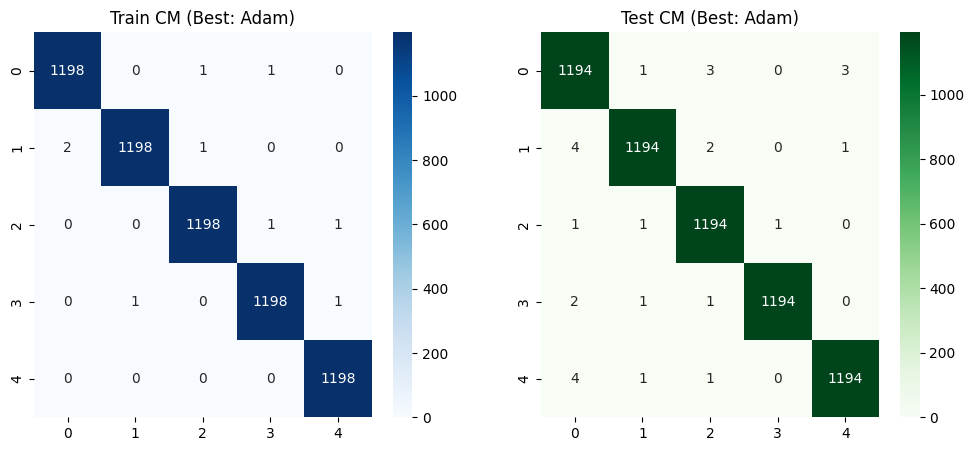

In [15]:
print(f"{'Arch':<25} {'Opt':<10} {'Ep':<5} {'TrAcc':<8} {'ValAcc':<8}")
print("-" * 60)
for i, d in R.items():
    for o, v in d.items():
        print(f"{str(arc[i]):<25} {o:<10} {v[0]:<5} {v[1]:.4f}   {v[2]:.4f}")

b_i, b_o, b_vm, b_tm, b_va = best['c']
print(f"\nBest: Arch={arc[b_i]}, Opt={b_o}, ValAcc={b_va:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(b_tm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Train CM (Best: {b_o})")
plt.subplot(1, 2, 2)
sns.heatmap(b_vm, annot=True, fmt='d', cmap='Greens')
plt.title(f"Test CM (Best: {b_o})")
plt.show()